In [1]:
from pyspark import SparkContext, RDD
import json
import matplotlib.pyplot as plt

sc = SparkContext()

23/05/28 22:11:08 WARN Utils: Your hostname, enriqueVB resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/05/28 22:11:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/28 22:11:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
rdd = sc.textFile("201906_Usage_Bicimad.json")
rdd.top(2)

['{ "_id" : { "$oid" : "5d193180a9cd6441ac491781" }, "user_day_code" : "a2859c578a940a5b6f9697d37bbb60887b59668b74f4abb3640db9eab8ecced8", "idplug_base" : 3, "user_type" : 1, "idunplug_base" : 19, "travel_time" : 301, "idunplug_station" : 30, "ageRange" : 5, "idplug_station" : 130, "unplug_hourTime" : { "$date" : "2019-06-26T23:00:00.000+0200" }, "zip_code" : "28010" }',
 '{ "_id" : { "$oid" : "5d193180a9cd6441ac491780" }, "user_day_code" : "a155966b8f5dfaeaac34612d902eab89b8dc590df6b9e9ca8b7888ed067e2290", "idplug_base" : 6, "user_type" : 1, "idunplug_base" : 6, "travel_time" : 2199, "idunplug_station" : 35, "ageRange" : 0, "idplug_station" : 2, "unplug_hourTime" : { "$date" : "2019-06-26T23:00:00.000+0200" }, "zip_code" : "" }']

In [3]:
def get_stations(line):
    data = json.loads(line)
    salida = data["idunplug_station"]
    entrada = data["idplug_station"]
    user = data["user_type"]
    franja_horaria = data["unplug_hourTime"]["$date"]
    return salida, entrada, user,franja_horaria
#Filtramos los usuarios, quedándonos con los de tipo 0 y 1 y eliminamos los trayectos que
#tienen por entrada y salida la misma estación
rdd1 = rdd.map(get_stations).filter(lambda x: x[2]<=1).filter(lambda x: x[0]!=x[1]) 



In [4]:
#Eliminamos los trayectos que tienen por entrada y salida la misma estación y 
#guardamos en rdd2 la tupla de los trayectos ordenada,1.
rdd2 = rdd1.map(lambda x: ((min(x[0],x[1]),max(x[0],x[1])),1)) 

rdd2.top(4)

[((207, 213), 1), ((207, 213), 1), ((207, 213), 1), ((207, 213), 1)]

In [25]:
rdd3 = rdd2.groupByKey().map(lambda x: (x[0], len(x[1])))
print(rdd3.max(key = (lambda x: x[1])))
maximo = rdd3.max(key = (lambda x: x[1]))[0]
rdd3.top(5)

((9, 149), 490)


[((207, 213), 7),
 ((207, 211), 6),
 ((201, 207), 1),
 ((200, 213), 1),
 ((200, 211), 5)]

In [6]:
lista_ordenados = rdd3.sortBy(lambda x : x[1]).collect()
lista_ordenados.reverse()
#lista_ordenados

In [30]:
lista_100mejores = lista_ordenados[:100]
print(lista_100mejores)
#lista_100mejores

[((9, 149), 490), ((49, 135), 434), ((132, 135), 405), ((64, 78), 402), ((149, 169), 380), ((149, 163), 358), ((130, 149), 357), ((157, 163), 322), ((132, 175), 317), ((58, 149), 312), ((26, 175), 310), ((135, 175), 310), ((129, 135), 288), ((57, 135), 284), ((64, 90), 282), ((47, 129), 281), ((52, 135), 280), ((27, 175), 271), ((9, 157), 268), ((118, 163), 266), ((38, 57), 262), ((86, 90), 261), ((1, 175), 260), ((9, 163), 258), ((38, 129), 257), ((129, 175), 253), ((84, 90), 252), ((160, 163), 251), ((42, 135), 249), ((48, 129), 246), ((49, 129), 244), ((57, 129), 243), ((56, 175), 240), ((129, 134), 237), ((83, 115), 236), ((162, 163), 235), ((153, 163), 235), ((130, 157), 229), ((133, 135), 228), ((132, 174), 227), ((149, 168), 226), ((169, 170), 226), ((59, 149), 224), ((45, 135), 223), ((42, 175), 221), ((57, 128), 215), ((79, 90), 213), ((45, 129), 213), ((160, 161), 211), ((26, 57), 210), ((38, 175), 209), ((134, 135), 209), ((30, 157), 206), ((73, 90), 206), ((50, 135), 205), 

In [11]:
rdd4 = rdd1.map(lambda x: (x[3],(min(x[0],x[1]),max(x[0],x[1]))))
rdd4.top(5)

[('2019-06-26T23:00:00.000+0200', (172, 174)),
 ('2019-06-26T23:00:00.000+0200', (172, 174)),
 ('2019-06-26T23:00:00.000+0200', (172, 173)),
 ('2019-06-26T23:00:00.000+0200', (172, 173)),
 ('2019-06-26T23:00:00.000+0200', (169, 200))]

In [12]:
mejores_trayectos = [x[0] for x in lista_100mejores]
rdd5 = rdd4.filter(lambda x : x[1] in mejores_trayectos)
rdd5.top(5)


[('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171)),
 ('2019-06-26T23:00:00.000+0200', (164, 171))]

In [19]:
rdd6 = rdd5.map(lambda x: ((x[1], x[0].split("T")[1]),1)).groupByKey().map(lambda x: (x[0] ,len(x[1])))

rdd6.top(5)

[(((169, 170), '23:00:00.000+0200'), 9),
 (((169, 170), '22:00:00.000+0200'), 2),
 (((169, 170), '21:00:00.000+0200'), 13),
 (((169, 170), '20:00:00.000+0200'), 19),
 (((169, 170), '19:00:00.000+0200'), 25)]

In [22]:
rdd7 = rdd6.map(lambda x: (x[0][0],(x[1],x[0][1]))).groupByKey().map(lambda x: (x[0],max(list(x[1]))))
rdd7.top() 

[((169, 170), (27, '10:00:00.000+0200')),
 ((164, 171), (48, '10:00:00.000+0200')),
 ((163, 170), (23, '20:00:00.000+0200'))]

In [24]:
listaResultados = rdd7.collect()
print(listaResultados)

[((9, 157), (35, '21:00:00.000+0200')), ((42, 132), (22, '00:00:00.000+0200')), ((9, 163), (60, '08:00:00.000+0200')), ((25, 175), (25, '18:00:00.000+0200')), ((13, 149), (20, '19:00:00.000+0200')), ((64, 90), (40, '08:00:00.000+0200')), ((38, 135), (18, '16:00:00.000+0200')), ((129, 134), (32, '20:00:00.000+0200')), ((50, 135), (23, '20:00:00.000+0200')), ((149, 164), (21, '09:00:00.000+0200')), ((160, 161), (29, '16:00:00.000+0200')), ((134, 135), (24, '19:00:00.000+0200')), ((149, 161), (22, '19:00:00.000+0200')), ((145, 161), (48, '08:00:00.000+0200')), ((19, 163), (40, '08:00:00.000+0200')), ((59, 131), (24, '00:00:00.000+0200')), ((64, 84), (38, '08:00:00.000+0200')), ((129, 175), (34, '19:00:00.000+0200')), ((42, 57), (24, '19:00:00.000+0200')), ((73, 90), (35, '09:00:00.000+0200')), ((59, 168), (24, '20:00:00.000+0200')), ((42, 135), (32, '16:00:00.000+0200')), ((149, 160), (22, '19:00:00.000+0200')), ((169, 170), (27, '10:00:00.000+0200')), ((65, 84), (30, '07:00:00.000+0200')

Con esto obtenemos los mejores trayectos, el número de veces que se realiza y las mejores horas de cada uno de esos trayectos, que es lo que queríamos 


Ahora veamos una gráfica de para la estacion con mayor frecuencia cómo varía el numero de bicis por hora

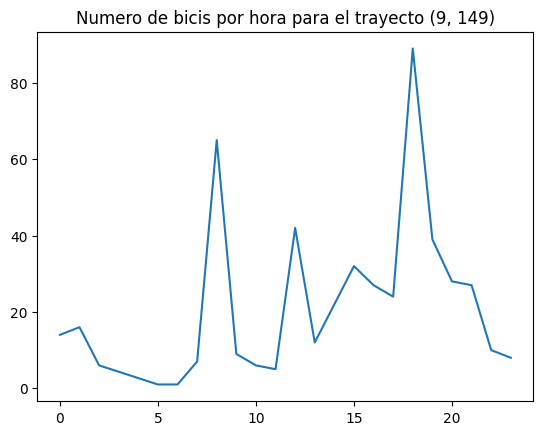

In [29]:
rddGraf = rdd6.filter(lambda x: x[0][0] == maximo).map(lambda x: (int(x[0][1][:2]), x[1])).sortBy(lambda x: x[0])
listaRes = rddGraf.collect()

lx = [x[0] for x in listaRes]
ly = [x[1] for x in listaRes]
plt.plot(lx, ly)
plt.title(f"Numero de bicis por hora para el trayecto {maximo}")
plt.show()

In [36]:
from pyspark import pandas
DF = pandas.DataFrame(data = lista_100mejores[:10], columns =["estacion", "numeroviajes"])

In [37]:
DF#Aqui podemos ver en una tabla los 10 mejores trayectos segun el numero de viajes

,estacion,numeroviajes
0,"[9, 149]",490
1,"[49, 135]",434
2,"[132, 135]",405
3,"[64, 78]",402
4,"[149, 169]",380
5,"[149, 163]",358
6,"[130, 149]",357
7,"[157, 163]",322
8,"[132, 175]",317
9,"[58, 149]",312
